In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import zlib
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

BASE_DIR = Path("..")
PRUNED_FILE = BASE_DIR / "data" / "intermediate_pruned.parquet"

print("=" * 80)
print("COMPREHENSIVE PRUNED DATASET ANALYSIS")
print("=" * 80)

COMPREHENSIVE PRUNED DATASET ANALYSIS


In [13]:
print("\nLoading pruned parquet file...\n")

df_full = pd.read_parquet(PRUNED_FILE)

print(f"File: intermediate_pruned.parquet")
print(f"Total loaded: {len(df_full)} rows")
print(f"Columns: {list(df_full.columns)}")
print(f"Memory usage: {df_full.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print("\nDataset Info:")
print(f'Unique samples: {df_full["sample_id"].nunique()}')
print(f'Unique params: {df_full["param_id"].nunique()}')
print(f'Image shape (first): {df_full["image_shape"].iloc[0]}')


Loading pruned parquet file...

File: intermediate_pruned.parquet
Total loaded: 2290 rows
Columns: ['sample_id', 'param_id', 'image_compressed', 'image_shape', 'input_params', 'microstructure_outputs', 'performance_outputs']
Memory usage: 390.5 MB

Dataset Info:
Unique samples: 49
Unique params: 54
Image shape (first): [128 128 128]


In [14]:
INPUT_FEATURES = [
    "SEI_kinetic_rate",
    "Electrolyte_diffusivity",
    "Initial_conc_electrolyte",
    "Separator_porosity",
    "Separator_Bruggeman_electrolyte",
    "Separator_Bruggeman",
    "Positive_particle_radius",
    "Negative_particle_radius",
    "Positive_electrode_thickness",
    "Negative_electrode_thickness",
]

MICROSTRUCTURE_FEATURES = [
    "D_eff",
    "porosity_measured",
    "tau_factor",
    "bruggeman_derived",
]

PERFORMANCE_FEATURES = [
    "eol_cycle_measured",
    "initial_capacity_Ah",
    "final_capacity_Ah",
    "capacity_retention_percent",
    "total_cycles",
]

# Expand input params
input_arrays = np.array(df_full["input_params"].tolist())
df_inputs = pd.DataFrame(input_arrays, columns=INPUT_FEATURES)

# Expand microstructure outputs
micro_arrays = np.array(df_full["microstructure_outputs"].tolist())
df_micro = pd.DataFrame(micro_arrays, columns=MICROSTRUCTURE_FEATURES)

# Expand performance outputs
perf_arrays = np.array(df_full["performance_outputs"].tolist())
df_perf = pd.DataFrame(perf_arrays, columns=PERFORMANCE_FEATURES)

# Combine all
df_expanded = pd.concat(
    [
        df_full[["sample_id", "param_id"]].reset_index(drop=True),
        df_inputs,
        df_micro,
        df_perf,
    ],
    axis=1,
)

print(f"Expanded dataset shape: {df_expanded.shape}")
print(f"Total columns: {len(df_expanded.columns)}")

Expanded dataset shape: (2290, 21)
Total columns: 21


In [15]:
# Calculate statistics for input features
input_stats = df_inputs.describe().T
input_stats["missing"] = df_inputs.isnull().sum()
input_stats["missing_pct"] = (input_stats["missing"] / len(df_inputs) * 100).round(2)

cols = [
    "count",
    "mean",
    "std",
    "min",
    "25%",
    "50%",
    "75%",
    "max",
    "missing",
    "missing_pct",
]
input_stats = input_stats[cols]

print(input_stats.to_string())

# Check for missing and constant features
missing_features = input_stats[input_stats["missing"] > 0]
constant_features = input_stats[input_stats["std"] == 0]

print("\nMissing features:")
print(missing_features[["missing", "missing_pct"]] if len(missing_features) else "None")

print("\nConstant features:")
print(constant_features[["mean"]] if len(constant_features) else "None")

                                  count          mean           std           min           25%           50%           75%           max  missing  missing_pct
SEI_kinetic_rate                 2290.0  7.587232e-14  1.087112e-13  1.080000e-15  4.780000e-15  2.110000e-14  1.030000e-13  4.730000e-13        0          0.0
Electrolyte_diffusivity          2290.0  2.980576e-10  5.730513e-11  2.000000e-10  2.500000e-10  2.970000e-10  3.440000e-10  3.980000e-10        0          0.0
Initial_conc_electrolyte         2290.0  1.000000e+03  0.000000e+00  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03        0          0.0
Separator_porosity               2290.0  5.892332e-01  2.976242e-02  5.380924e-01  5.635579e-01  5.914245e-01  6.170759e-01  6.363797e-01        0          0.0
Separator_Bruggeman_electrolyte  2290.0  2.673171e+00  1.545800e-01  2.415743e+00  2.540437e+00  2.670941e+00  2.808147e+00  2.928699e+00        0          0.0
Separator_Bruggeman              2290.0 

In [16]:
# Calculate statistics for microstructure features
micro_stats = df_micro.describe().T
micro_stats["missing"] = df_micro.isnull().sum()
micro_stats["missing_pct"] = (micro_stats["missing"] / len(df_micro) * 100).round(2)
micro_stats = micro_stats[cols]

print(micro_stats.to_string())

print("\nMicrostructure correlation matrix:")
print(df_micro.corr().to_string())

                    count      mean       std       min       25%       50%       75%       max  missing  missing_pct
D_eff              2290.0  0.377950  0.132309  0.140768  0.275735  0.380594  0.467839  0.633595        0          0.0
porosity_measured  2290.0  0.651967  0.088672  0.447664  0.581699  0.670159  0.722831  0.815443        0          0.0
tau_factor         2290.0  1.897509  0.541320  1.179202  1.508816  1.635382  2.272830  3.402358        0          0.0
bruggeman_derived  2290.0  2.371142  0.370987  1.565469  2.141676  2.385609  2.666853  3.149454        0          0.0

Microstructure correlation matrix:
                      D_eff  porosity_measured  tau_factor  bruggeman_derived
D_eff              1.000000           0.897883   -0.910685          -0.509548
porosity_measured  0.897883           1.000000   -0.734925          -0.088107
tau_factor        -0.910685          -0.734925    1.000000           0.666432
bruggeman_derived -0.509548          -0.088107    0.666432    

In [17]:
# Calculate statistics for performance features
perf_stats = df_perf.describe().T
perf_stats["missing"] = df_perf.isnull().sum()
perf_stats["missing_pct"] = (perf_stats["missing"] / len(df_perf) * 100).round(2)
perf_stats = perf_stats[cols]

print(perf_stats.to_string())

# Specific statistics
retention = df_perf["capacity_retention_percent"].dropna()
cycles = df_perf["total_cycles"].dropna()
eol_cycles = df_perf["eol_cycle_measured"].dropna()

print("\nRetention summary:")
print(retention.describe())

print("\nCycle summary:")
print(f"Mean total cycles: {cycles.mean():.1f}")
print(f"Mean EOL cycles: {eol_cycles.mean():.1f}")

                             count        mean         std        min        25%        50%         75%         max  missing  missing_pct
eol_cycle_measured          2290.0   18.198690   50.143606   1.000000   1.000000   1.000000   10.000000  458.000000        0          0.0
initial_capacity_Ah         2290.0    3.426959    1.008023   1.186405   2.616975   3.311424    4.318718    5.370603        0          0.0
final_capacity_Ah           2290.0    2.535351    0.778879   0.802776   1.922685   2.438161    3.215426    3.995838        0          0.0
capacity_retention_percent  2290.0   73.700339    1.929798  67.411235  72.314925  73.710054   75.210181   79.589797        0          0.0
total_cycles                2290.0  118.188646  137.149194   8.000000  26.000000  52.000000  155.750000  500.000000        0          0.0

Retention summary:
count    2290.000000
mean       73.700339
std         1.929798
min        67.411235
25%        72.314925
50%        73.710054
75%        75.210181
max  

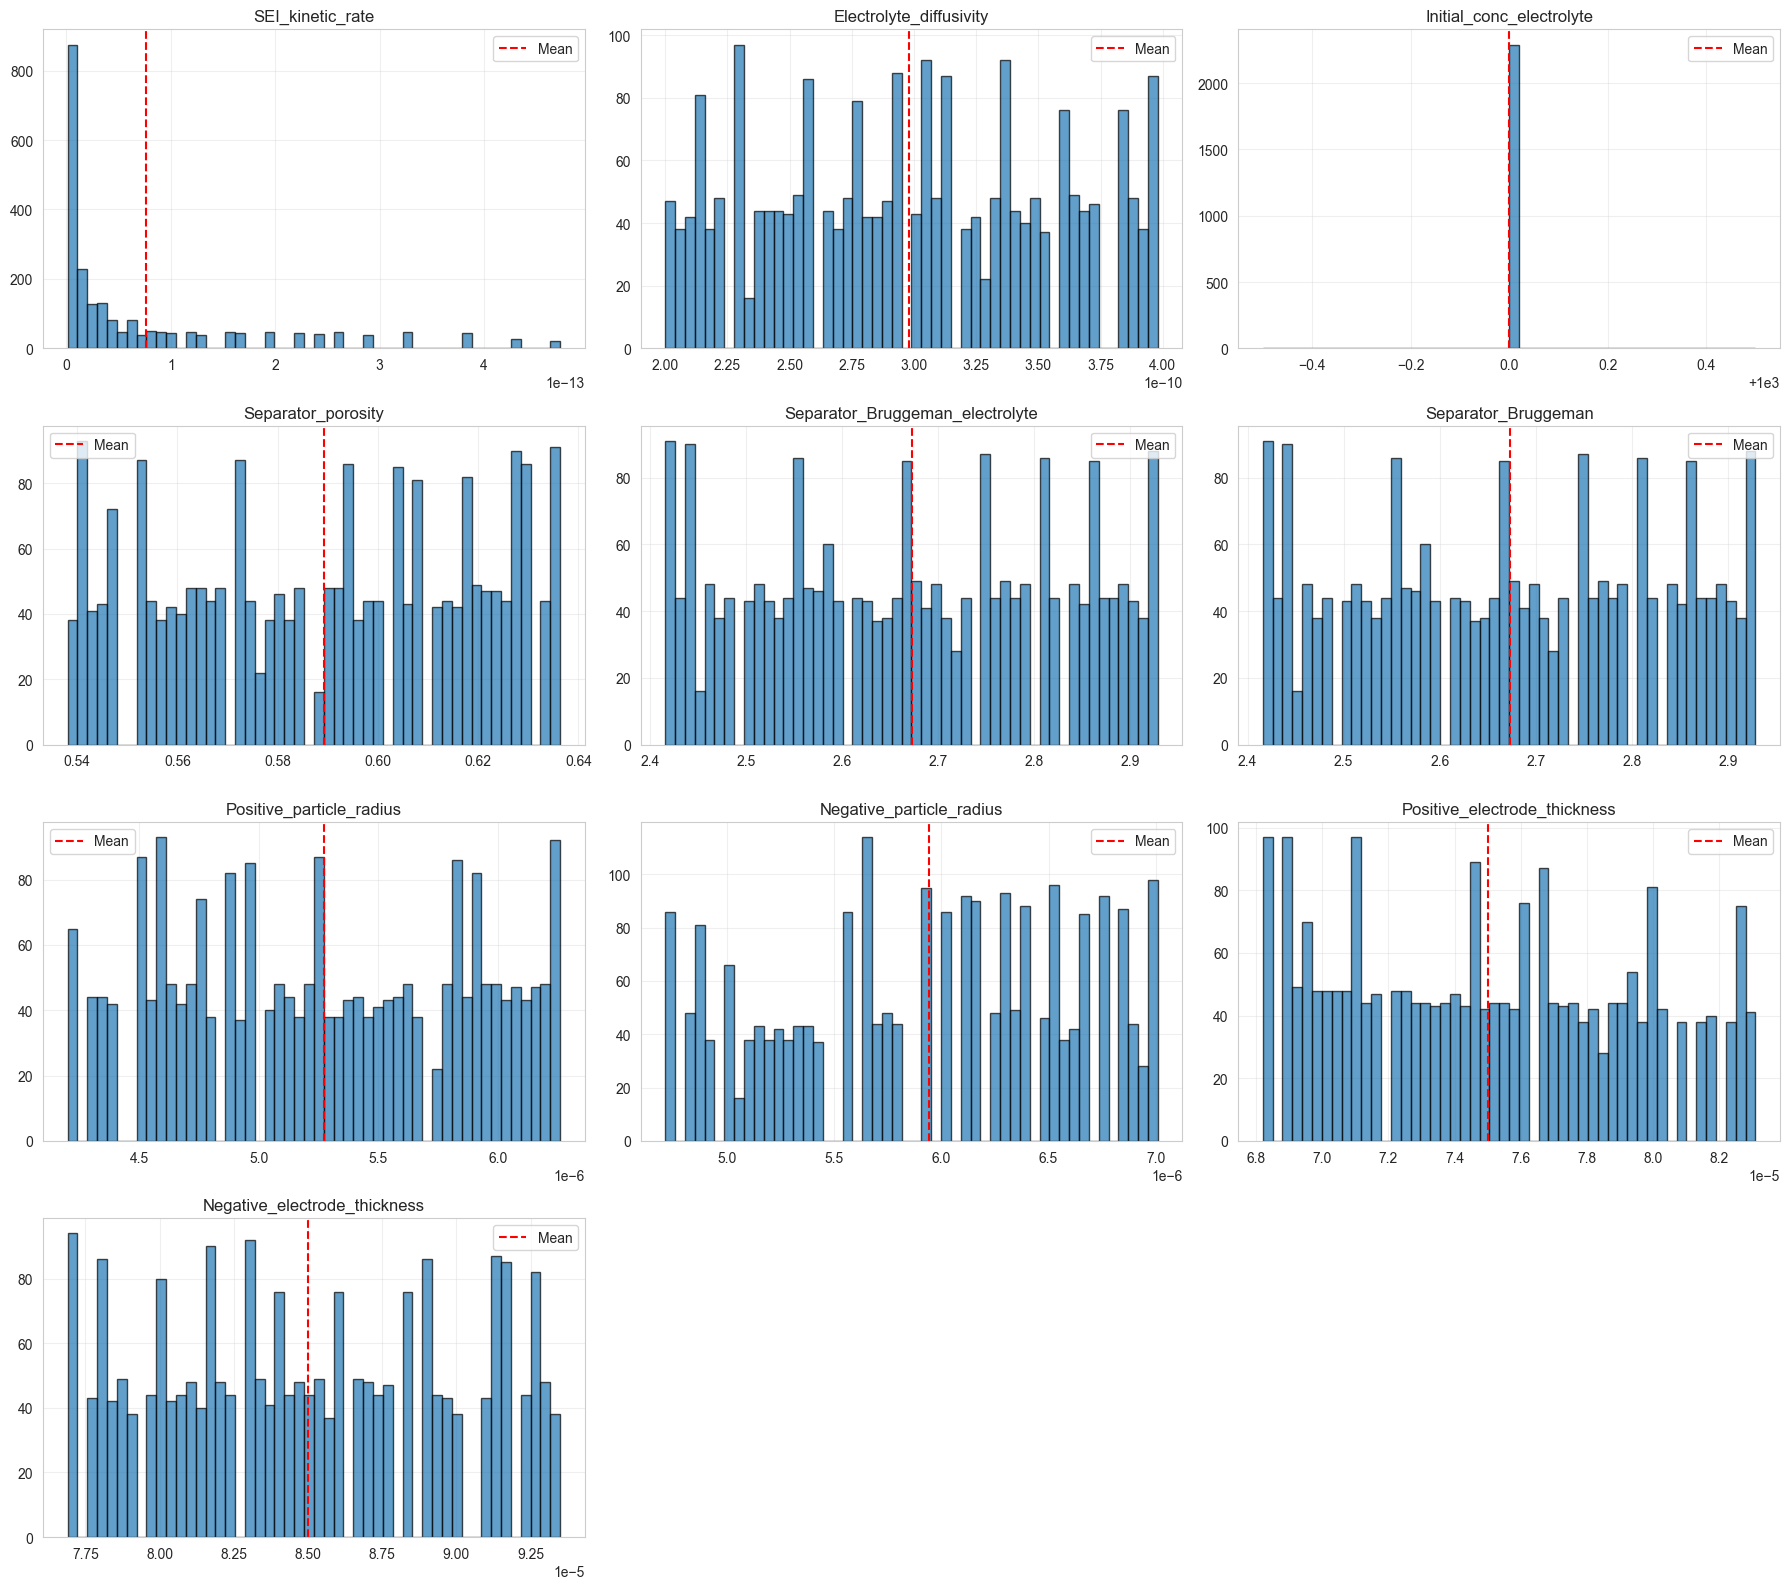

In [18]:
n_features = len(INPUT_FEATURES)
ncols = 3
nrows = (n_features + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows))
axes = axes.flatten()

for idx, feat in enumerate(INPUT_FEATURES):
    data = df_inputs[feat].dropna()
    ax = axes[idx]
    ax.hist(data, bins=50, alpha=0.7, edgecolor="black")
    ax.axvline(data.mean(), linestyle="--", color="red", label="Mean")
    ax.set_title(feat)
    ax.grid(True, alpha=0.3)
    ax.legend()

for idx in range(n_features, len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

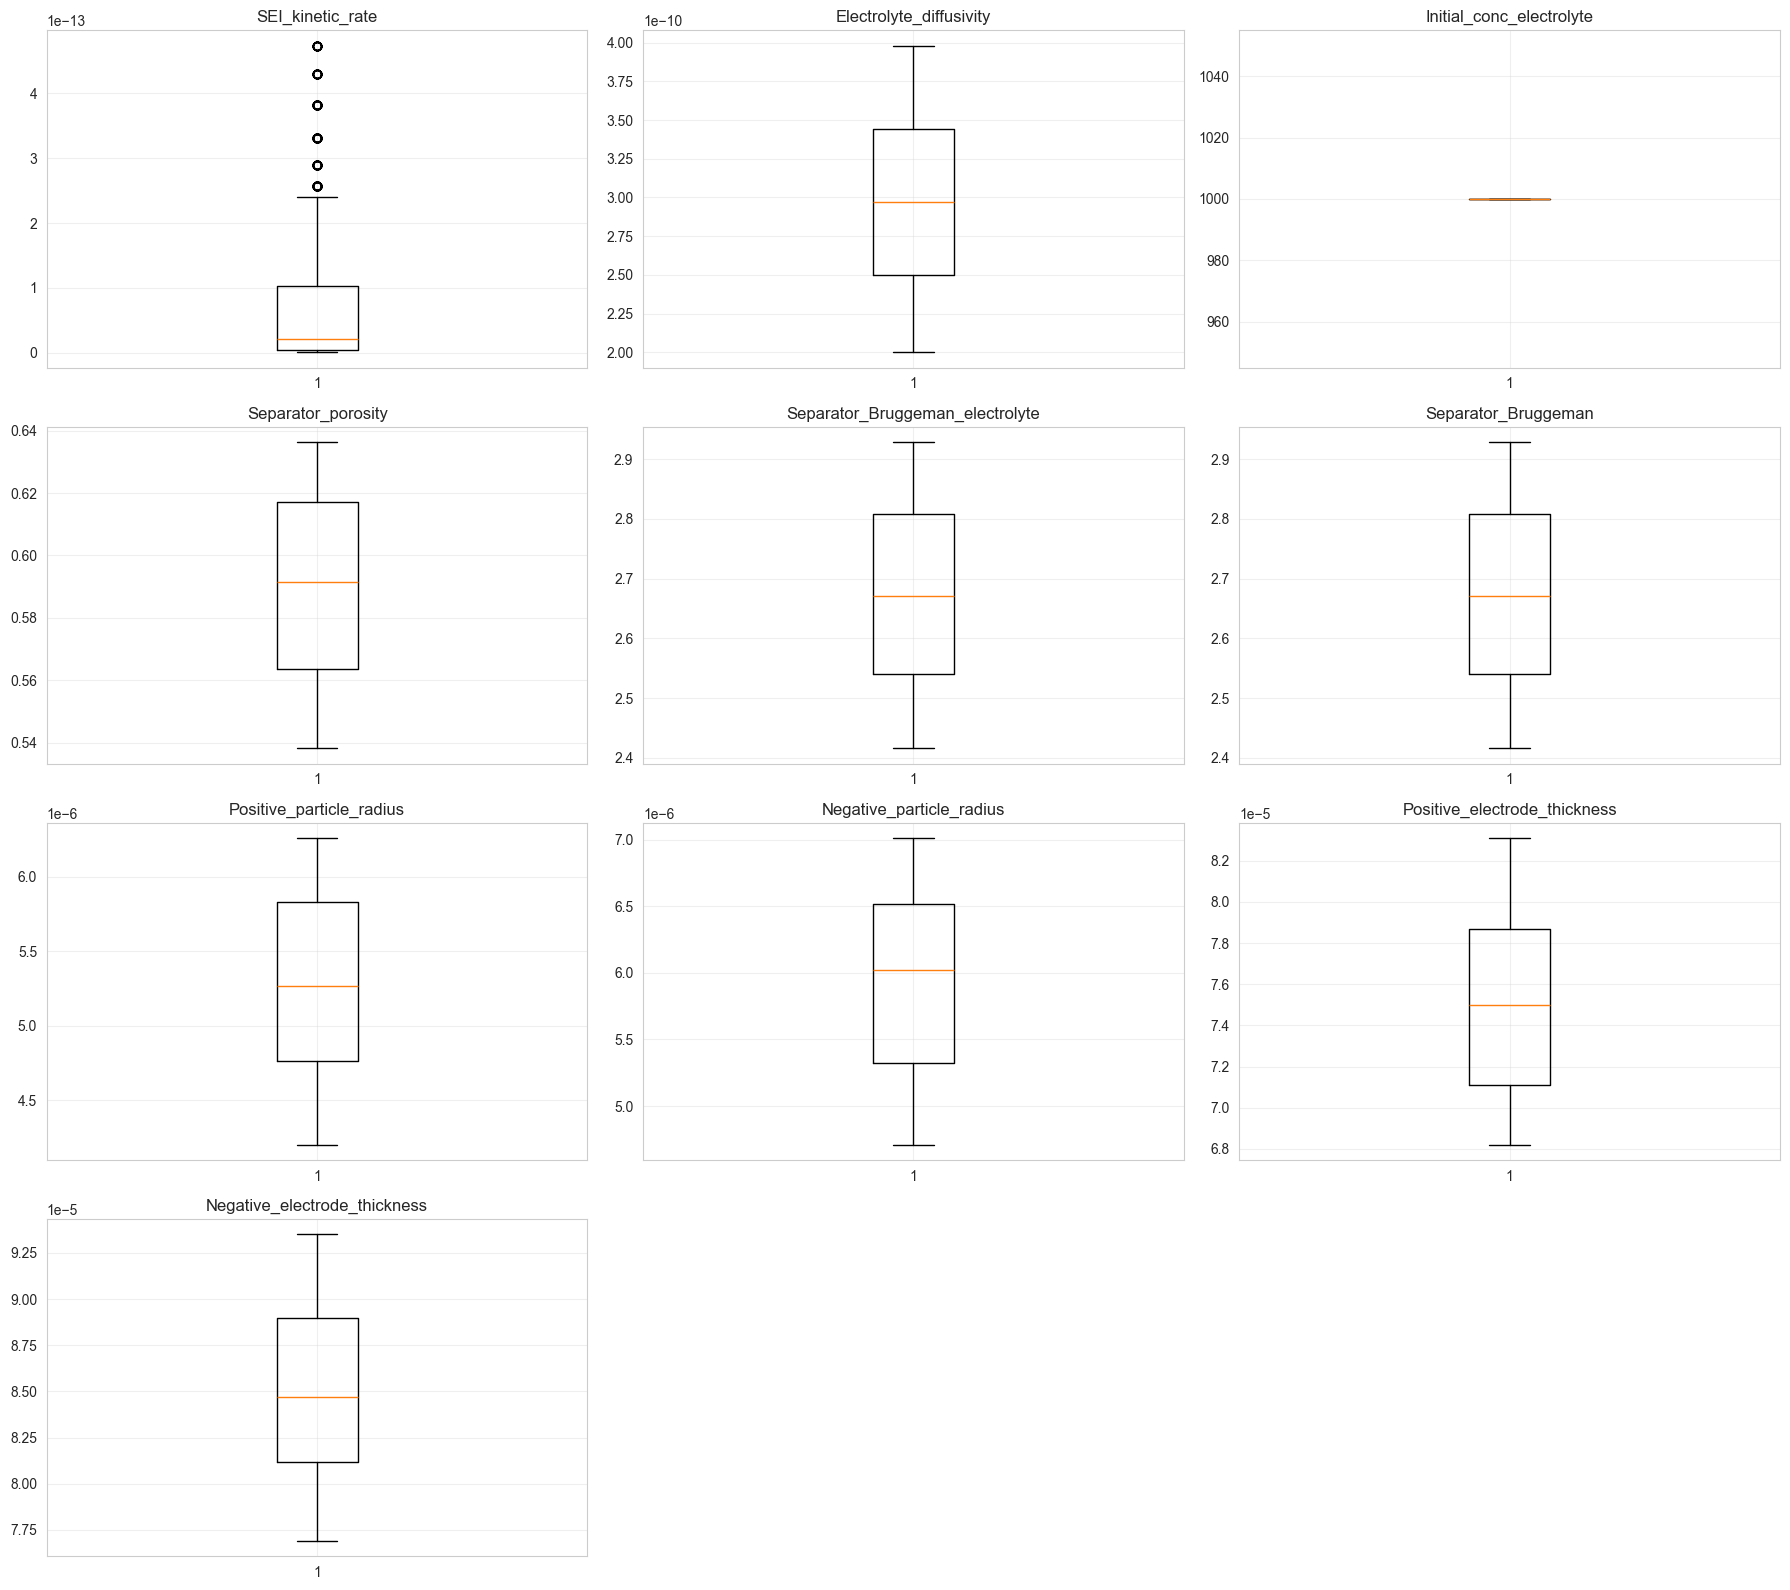

In [19]:
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows))
axes = axes.flatten()

for idx, feat in enumerate(INPUT_FEATURES):
    data = df_inputs[feat].dropna()
    ax = axes[idx]
    ax.boxplot(data, vert=True)
    ax.set_title(feat)
    ax.grid(True, alpha=0.3)

for idx in range(n_features, len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

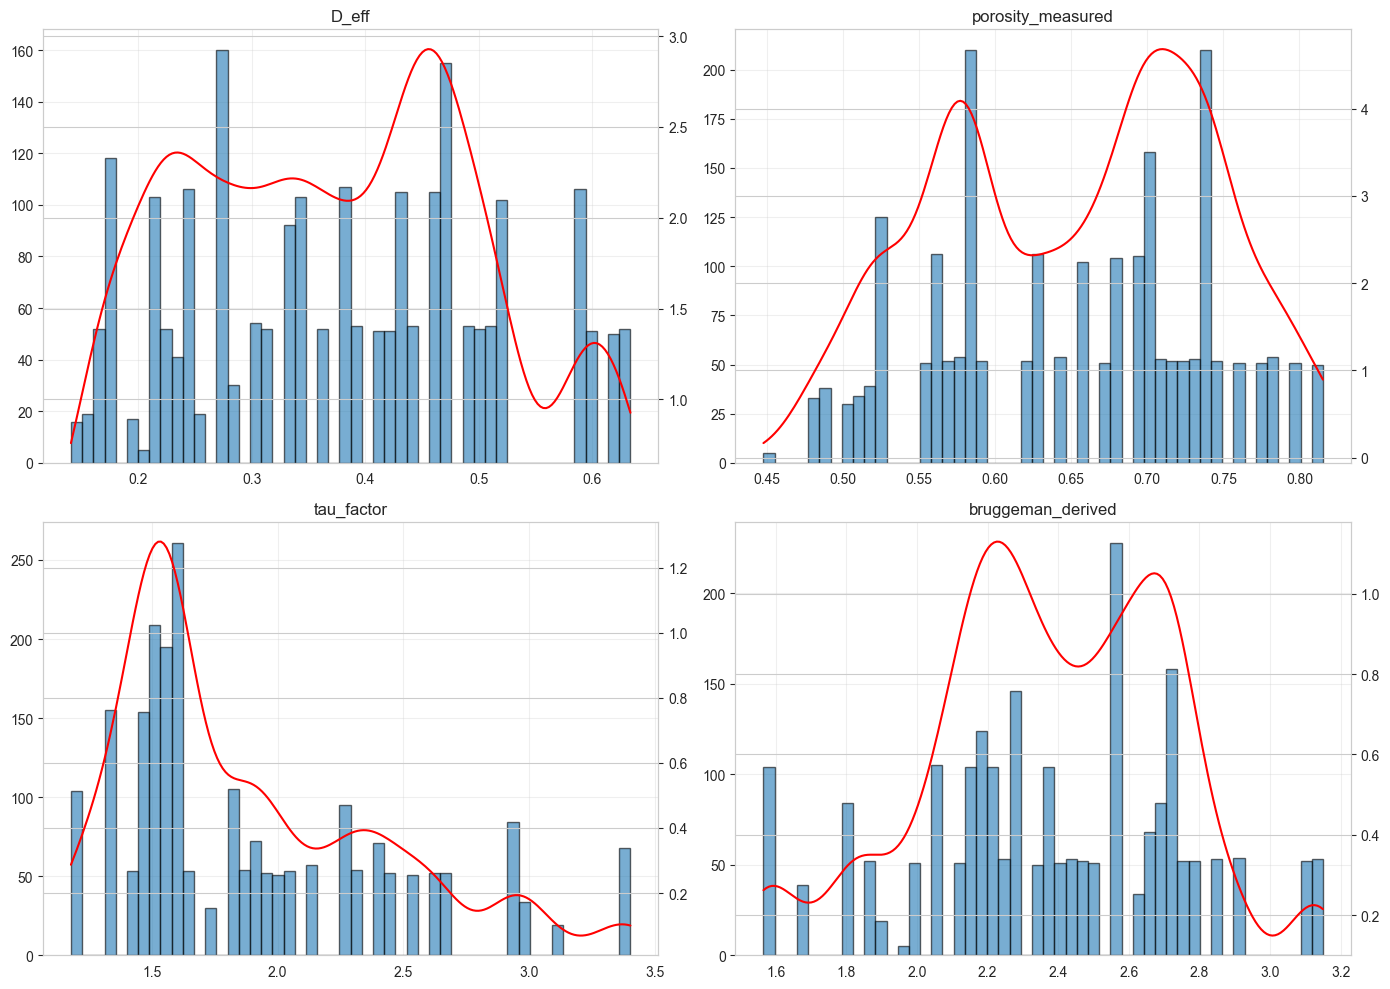

In [20]:
from scipy import stats

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feat in enumerate(MICROSTRUCTURE_FEATURES):
    data = df_micro[feat].dropna()
    ax = axes[idx]
    ax.hist(data, bins=50, alpha=0.6, edgecolor="black", label="Data")

    # Add KDE
    density = stats.gaussian_kde(data)
    xs = np.linspace(data.min(), data.max(), 200)
    ax2 = ax.twinx()
    ax2.plot(xs, density(xs), "r-", label="KDE")

    ax.set_title(feat)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

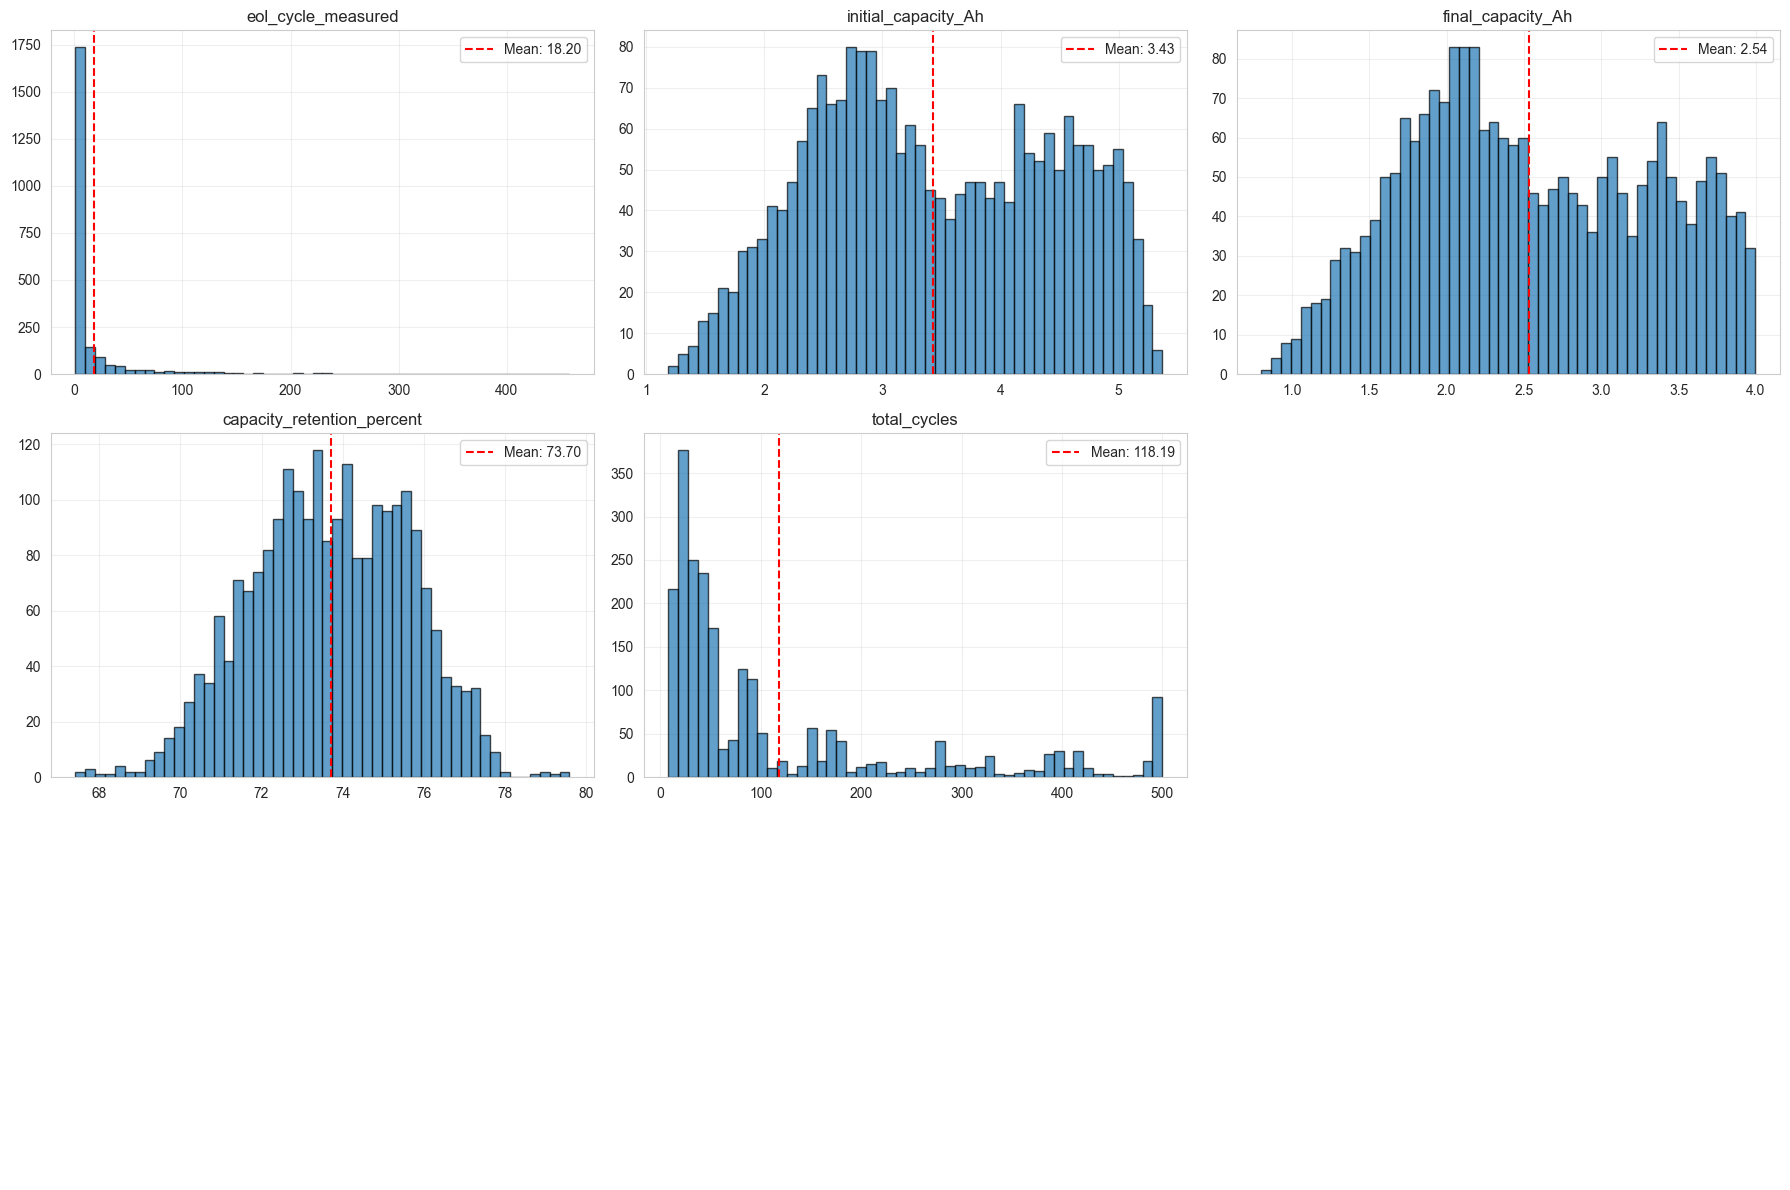

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, feat in enumerate(PERFORMANCE_FEATURES):
    data = df_perf[feat].dropna()
    if len(data) > 0:
        ax = axes[idx]
        ax.hist(data, bins=50, alpha=0.7, edgecolor="black")
        ax.axvline(
            data.mean(), linestyle="--", color="red", label=f"Mean: {data.mean():.2f}"
        )
        ax.set_title(feat)
        ax.grid(True, alpha=0.3)
        ax.legend()
    else:
        axes[idx].text(0.5, 0.5, "No data", ha="center", va="center")
        axes[idx].set_title(feat)

for idx in range(len(PERFORMANCE_FEATURES), len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

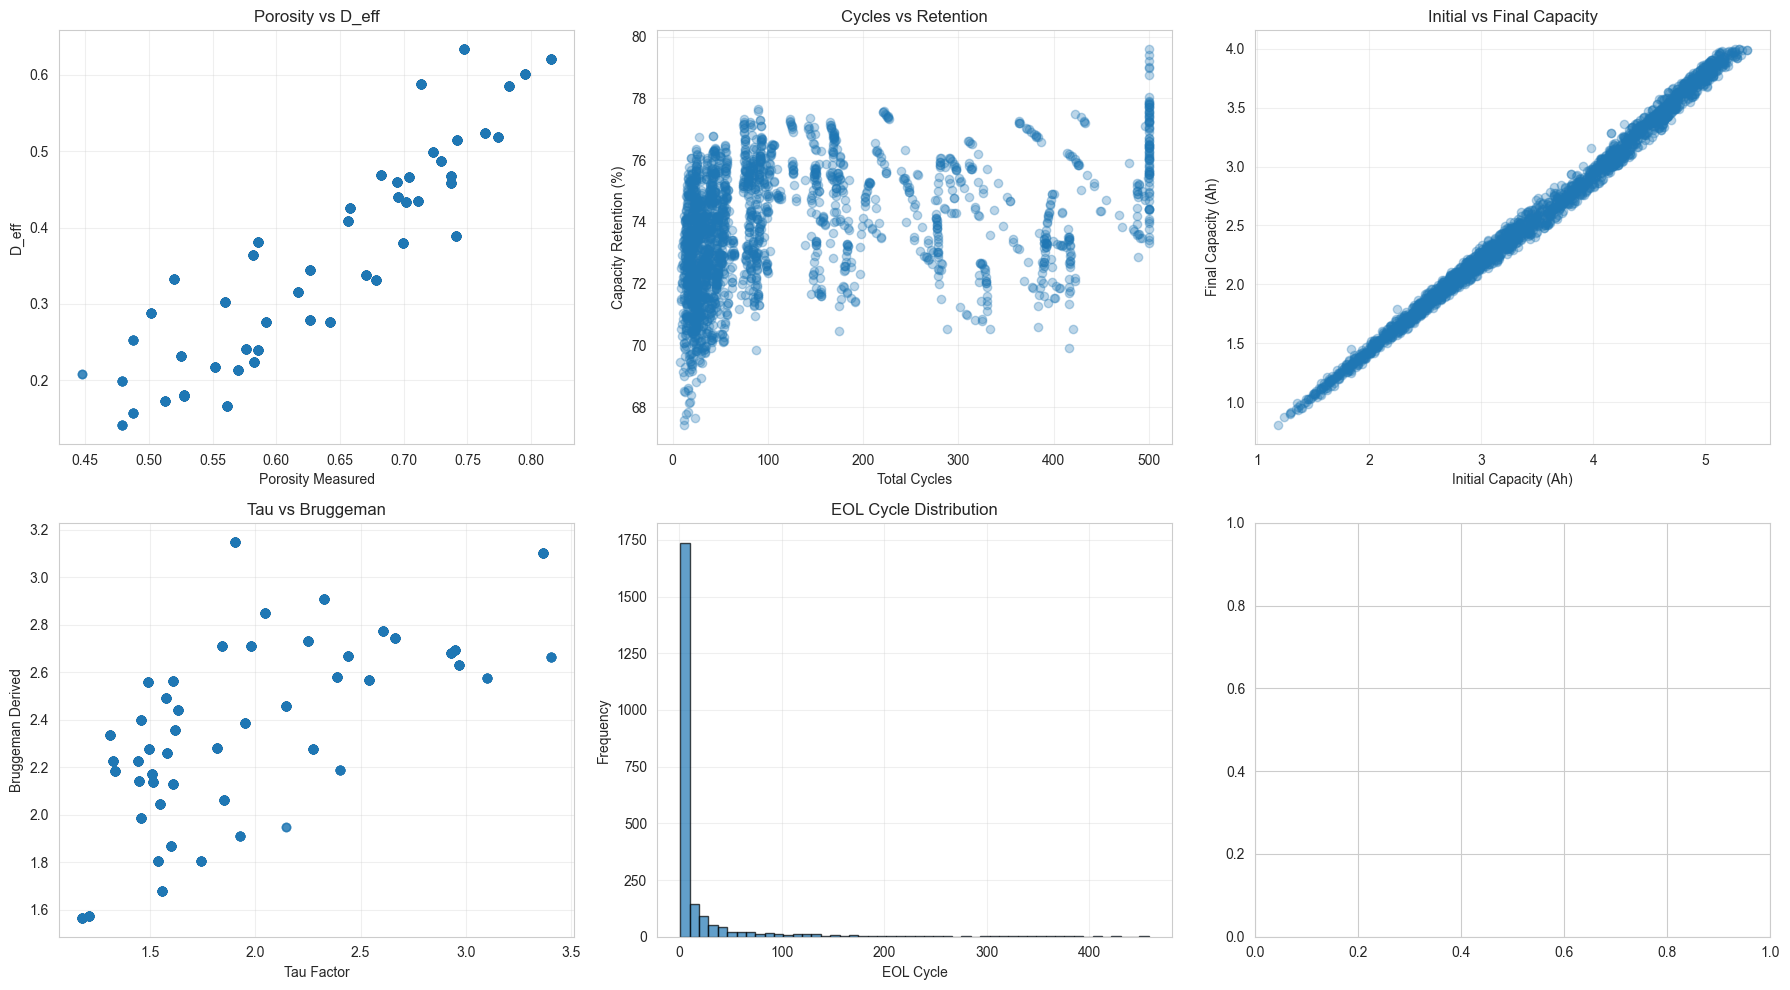

In [22]:
# Plot some key relationships
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Porosity vs D_eff
ax = axes[0, 0]
valid_data = df_expanded[["porosity_measured", "D_eff"]].dropna()
ax.scatter(valid_data["porosity_measured"], valid_data["D_eff"], alpha=0.3)
ax.set_xlabel("Porosity Measured")
ax.set_ylabel("D_eff")
ax.set_title("Porosity vs D_eff")
ax.grid(True, alpha=0.3)

# Plot 2: Total cycles vs Capacity retention
ax = axes[0, 1]
valid_data = df_expanded[["total_cycles", "capacity_retention_percent"]].dropna()
ax.scatter(
    valid_data["total_cycles"], valid_data["capacity_retention_percent"], alpha=0.3
)
ax.set_xlabel("Total Cycles")
ax.set_ylabel("Capacity Retention (%)")
ax.set_title("Cycles vs Retention")
ax.grid(True, alpha=0.3)

# Plot 3: Initial vs Final capacity
ax = axes[0, 2]
valid_data = df_expanded[["initial_capacity_Ah", "final_capacity_Ah"]].dropna()
ax.scatter(
    valid_data["initial_capacity_Ah"], valid_data["final_capacity_Ah"], alpha=0.3
)
ax.set_xlabel("Initial Capacity (Ah)")
ax.set_ylabel("Final Capacity (Ah)")
ax.set_title("Initial vs Final Capacity")
ax.grid(True, alpha=0.3)

# Plot 4: Bruggeman derived vs tau factor
ax = axes[1, 0]
valid_data = df_expanded[["tau_factor", "bruggeman_derived"]].dropna()
ax.scatter(valid_data["tau_factor"], valid_data["bruggeman_derived"], alpha=0.3)
ax.set_xlabel("Tau Factor")
ax.set_ylabel("Bruggeman Derived")
ax.set_title("Tau vs Bruggeman")
ax.grid(True, alpha=0.3)

# Plot 5: EOL cycles distribution
ax = axes[1, 1]
eol_data = df_expanded["eol_cycle_measured"].dropna()
if len(eol_data) > 0:
    ax.hist(eol_data, bins=50, alpha=0.7, edgecolor="black")
    ax.set_xlabel("EOL Cycle")
    ax.set_ylabel("Frequency")
    ax.set_title("EOL Cycle Distribution")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
print("=" * 80)
print("PRUNED DATASET SUMMARY REPORT")
print("=" * 80)

print(f"\nTotal samples: {len(df_full)}")
print(f'Unique sample IDs: {df_full["sample_id"].nunique()}')
print(f'Unique param IDs: {df_full["param_id"].nunique()}')

print(f"\nInput features: {len(INPUT_FEATURES)}")
print(f"Microstructure features: {len(MICROSTRUCTURE_FEATURES)}")
print(f"Performance features: {len(PERFORMANCE_FEATURES)}")

print("\nData Completeness:")
total_missing = df_expanded.isnull().sum().sum()
total_values = df_expanded.size
completeness = (1 - total_missing / total_values) * 100
print(f"Overall completeness: {completeness:.2f}%")

print("\nMissing values per feature group:")
print(
    f"Input features: {df_inputs.isnull().sum().sum()} / {df_inputs.size} ({df_inputs.isnull().sum().sum() / df_inputs.size * 100:.2f}%)"
)
print(
    f"Microstructure features: {df_micro.isnull().sum().sum()} / {df_micro.size} ({df_micro.isnull().sum().sum() / df_micro.size * 100:.2f}%)"
)
print(
    f"Performance features: {df_perf.isnull().sum().sum()} / {df_perf.size} ({df_perf.isnull().sum().sum() / df_perf.size * 100:.2f}%)"
)

print("\n" + "=" * 80)

PRUNED DATASET SUMMARY REPORT

Total samples: 2290
Unique sample IDs: 49
Unique param IDs: 54

Input features: 10
Microstructure features: 4
Performance features: 5

Data Completeness:
Overall completeness: 100.00%

Missing values per feature group:
Input features: 0 / 22900 (0.00%)
Microstructure features: 0 / 9160 (0.00%)
Performance features: 0 / 11450 (0.00%)

